# Optimisation de la variance montecarlo par variable de controle
Dans ce notebook on  explore et quantifie l'efficacité de la méthode de réduction de variance par Variables de controle dans le cadre de l'estimation du prix d'un Call Européen par simulation Monte Carlo.

In [4]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:


# ------------------------------------------------------------------
# Imports des bibliothèques standard 
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# Importations nécessaires pour corriger le chemin d'accès
import sys
import os

# ------------------------------------------------------------------
# CORRECTION DU CHEMIN D'ACCÈS POUR LES IMPORTS LOCAUX
# Le Notebook étant dans 'notebooks/', nous ajoutons le répertoire parent (MBG_MONTECARLO)
# au chemin de recherche Python(PYTHONPATH) pour trouver le dossier 'src'.
# ------------------------------------------------------------------

# Obtient le chemin absolu du répertoire de travail actuel
# (Ex: /chemin/vers/MBG_MONTECARLO/notebooks)
current_dir = os.getcwd() 

# Remonte au répertoire parent (Ex: /chemin/vers/MBG_MONTECARLO)
parent_dir = os.path.dirname(current_dir)

# Ajoute le répertoire parent à sys.path. 
# Maintenant, Python sait que 'src' est un sous-dossier valide.
sys.path.append(parent_dir)


# ------------------------------------------------------------------
# IMPORTATIONS DES FONCTIONS SOURCES
# ------------------------------------------------------------------

from src.estimateur_montecarlo import  vrai_prix_call 

from src.control_variate import  prix_mc_control_variate_call



# ------------------------------------------------------------------
# Définition des paramètres fondamentaux de l'option
# ------------------------------------------------------------------
S0 = 100.0   # Prix initial du sous-jacent
K = 100.0    # Prix d'exercice (Strike)
r = 0.05     # Taux sans risque
sigma = 0.2  # Volatilité
T = 1.0      # Temps jusqu'à l'échéance (en années)

#---------------------------------------------------------------
#Parametre de simulation pour la quantification
#---------------------------------------------------------------

N_paths = 50000      # Nombre de PAIRES/REALISATIONS par run (doit être élevé pour assurer la convergence)
N_runs = 200         # Nombre de répétitions pour estimer la variance de l'estimateur (doit être élevé)

#---------------------------------------------------------------
#Parametre pour la génération de nombre aléatoire
#---------------------------------------------------------------

seed = 21



## Quantification du Facteur d'Accélération ($\mathcal{S}$)
Nous exécutons $N_{\text{runs}}$ répétitions pour estimer la variance de chaque estimateur $\text{Var}(\widehat{{C}})$.

### Execution de la quantification

In [8]:
print("\n=======================================================")
print("ANALYSE QUANTITATIVE : VARIABLES DE CONTRÔLE (VC)")
print("=======================================================")
print(f"Comparaison basée sur N_runs = {N_runs} répétitions, avec N = {N_paths} chemins par run.")

results_std = np.zeros(N_runs)
results_cv = np.zeros(N_runs)
alpha_history = np.zeros(N_runs)
C_BS = vrai_prix_call(S0, K, r, sigma, T)


for i in range(N_runs):
    # Utiliser un seed différent pour garantir l'indépendance des runs
    seed_i = seed + i
    
    # La fonction retourne le prix VC corrigé (C_cv) et le prix Standard (C_mc_X)
    # Le prix Standard (C_mc_X) est utilisé ici comme référence Var_Std.
    C_cv, C_mc_X, alpha_hat = prix_mc_control_variate_call(
        S0, K, r, sigma, T, N_paths, C_BS,seed=seed_i
    )
    
    results_std[i] = C_mc_X
    results_cv[i] = C_cv
    alpha_history[i] = alpha_hat


# --- Calcul des Statistiques ---

var_std = np.var(results_std, ddof=1)
var_cv = np.var(results_cv, ddof=1)
FA_cv = var_std / var_cv

mean_alpha = np.mean(alpha_history)


ANALYSE QUANTITATIVE : VARIABLES DE CONTRÔLE (VC)
Comparaison basée sur N_runs = 200 répétitions, avec N = 50000 chemins par run.


### Resultats tabulaires

In [9]:
# --- Affichage des Résultats ---

print("\n--- Résultats de la Quantification (Variables de Contrôle) ---")
print(f"Coefficient Alpha optimal estimé (Moyenne) : {mean_alpha:.4f} (Théorie : 1.0)")

print("\n| Méthode | Prix Moyen Estimé | Variance Empirique (Efficacité) | Écart-Type (Erreur MC) | Facteur S |")
print("| :---: | :---: | :---: | :---: | :---: |")
print(f"| Standard | {np.mean(results_std):.4f} | {var_std:.6e} | {np.sqrt(var_std):.4e} | 1.00 |")
print(f"| Control Variates | {np.mean(results_cv):.4f} | {var_cv:.6e} | {np.sqrt(var_cv):.4e} | {FA_cv:.2f} |")

print("\nConclusion: La méthode VC atteint un Facteur d'Accélération (S) très élevé, confirmant sa supériorité en gain de variance brute.")
print(f"Pour ce cas où X=Y, le gain est colossal (S={FA_cv:.2f}).")


--- Résultats de la Quantification (Variables de Contrôle) ---
Coefficient Alpha optimal estimé (Moyenne) : 1.0000 (Théorie : 1.0)

| Méthode | Prix Moyen Estimé | Variance Empirique (Efficacité) | Écart-Type (Erreur MC) | Facteur S |
| :---: | :---: | :---: | :---: | :---: |
| Standard | 10.4488 | 5.012043e-03 | 7.0796e-02 | 1.00 |
| Control Variates | 10.4506 | 2.004897e-12 | 1.4159e-06 | 2499900001.17 |

Conclusion: La méthode VC atteint un Facteur d'Accélération (S) très élevé, confirmant sa supériorité en gain de variance brute.
Pour ce cas où X=Y, le gain est colossal (S=2499900001.17).


## Visualisation avec un boxplot

### Execution du graphique


In [ ]:

# Supposons que results_std, results_anti, et results_cv sont les tableaux remplis
# C_BS est le prix analytique (e.g., 10.4506)

def plot_combined_box_plot(results_std, results_cv, C0):
    
    data = [results_std, results_cv]
    labels = [
        'MCS (Standard)', 
        'Variables de Contrôle (VC)'
    ]
    
    # Calcul des Facteurs d'Accélération (pour affichage dans le titre)
    var_std = np.var(results_std, ddof=1)
    #var_anti = np.var(results_anti, ddof=1)
    var_cv = np.var(results_cv, ddof=1)
    
    #FA_anti = var_std / var_anti
    FA_cv = var_std / var_cv
    
    plt.figure(figsize=(12, 7))
    
    # Création du Box-Plot
    plt.boxplot(data, labels=labels, vert=True, patch_artist=True, 
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red', linewidth=2))
    
    # Ligne de référence analytique
    plt.axhline(C0, color='darkgreen', linestyle='--', linewidth=1.5, label=f'Prix Théorique BS ({C0:.4f})')
    
    # Annotations des Facteurs d'Accélération
    plt.text(1, plt.ylim()[1] * 0.95, f'S=1.00', ha='center', fontsize=10)
   # plt.text(2, plt.ylim()[1] * 0.95, f'S={FA_anti:.2f}', ha='center', fontsize=10)
    plt.text(2, plt.ylim()[1] * 0.95, f'S={FA_cv:.2f}', ha='center', fontsize=10, weight='bold')
    
    plt.title(f'Comparaison de la Dispersion des Estimateurs MC (S Total = {FA_cv:.2f})', fontsize=16)
    plt.ylabel('Prix Estimé', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()


### Graphique boxplot

C:\Users\Guy Groguhe\AppData\Local\Temp\ipykernel_22688\1242085015.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, vert=True, patch_artist=True,


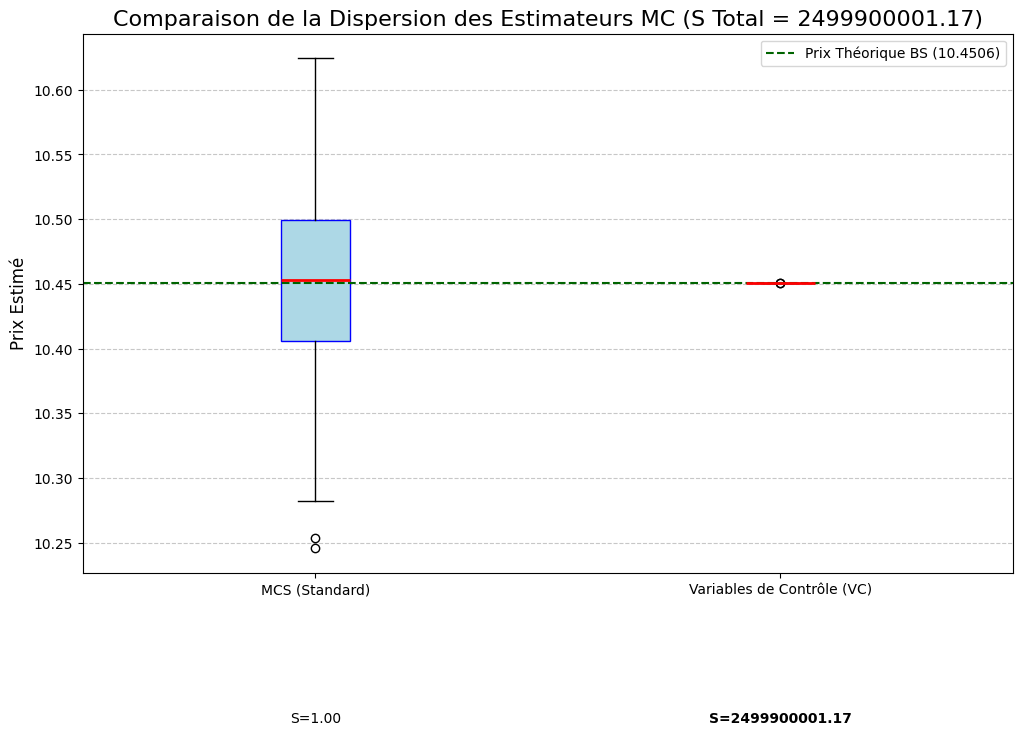

In [14]:
# prix de reference Black Scholes

C_BS = vrai_prix_call(S0, K, r, sigma, T)

# Affichage du Box-Plot

plot_combined_box_plot(results_std, results_cv, C_BS)

# Image visuelle du Box Plot
